<a href="https://colab.research.google.com/github/simonwoodhead/course-v3/blob/master/collab_questions_answer_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from pathlib import Path
root_dir = Path('/content/gdrive/My Drive/')
base_dir = root_dir/'fastai-v3/'

Mounted at /content/gdrive


## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [0]:
user,item = 'UserId','QuestionIdAnswerValue'

**TODO: Refactor to use the categories property when creating the CollabDataBunch**

---



---



In [0]:
answers = pd.read_csv(base_dir/'data/answers/IncorrectAnswersWithValuesv2.csv')
series2cat(answers, user, item)
answers.head()

,UserId,QuestionIdAnswerValue,WhetherThisAnswerChosen
0,1264152,77906-A,0
1,1263954,77910-A,0
2,1263954,77911-A,1
3,1263870,78334-A,0
4,1263870,78335-A,1


In [0]:
answers.dtypes

UserId                     category
QuestionIdAnswerValue      category
WhetherThisAnswerChosen       int64
dtype: object

That's all we need to create and train a model:

In [0]:
data = CollabDataBunch.from_df(answers, seed=42, valid_pct=0.1, )

The loss function is actually associated with the data bunch. See that it is stored under the train_ds.y property.

In [0]:
data.train_ds.y.loss_func

FlattenedLoss of MSELoss()

In [0]:
y_range = [-0.2,1.2]

In [0]:
data.show_batch()

UserId,QuestionIdAnswerValue,target
1286046,76905-D,1.0
1347870,78625-B,0.0
1264033,78979-C,1.0
1232755,78310-D,0.0
1263740,77988-A,0.0


In [0]:
len(answers), len(data.train_ds), len(data.valid_ds)

(290430, 261387, 29043)

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


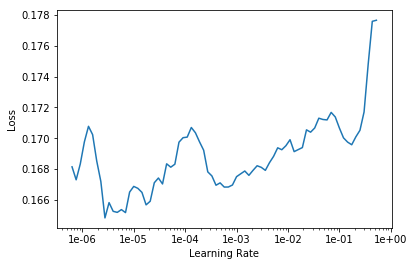

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(5, 5e-6)

epoch,train_loss,valid_loss,time
0,0.172033,0.196877,00:25
1,0.171740,0.196853,00:26
2,0.170195,0.196832,00:25
3,0.172258,0.196822,00:25
4,0.169404,0.196820,00:26


In [0]:
learn.save('dotprod')

## Interpretation

### Setup

In [0]:
learn.load('dotprod');

In [0]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(1001, 50)
  (i_weight): Embedding(3001, 50)
  (u_bias): Embedding(1001, 1)
  (i_bias): Embedding(3001, 1)
)

In [0]:
# Order the questions by the ones with the most answers
g = answers.groupby(item)['WhetherThisAnswerChosen'].sum()
top_questions = g.sort_values(ascending=False).index.values[:4000]
top_questions[:10]

[78235-B, 78220-D, 77905-C, 78227-D, 77805-A, 78134-B, 73611-B, 78242-A, 78243-B, 73664-C]
Categories (3000, object): [73583-A < 73583-B < 73583-C < 73584-A ... 79852-C < 79853-A < 79853-B <
                            79853-D]

### Question bias

When a student answers a question they may get it correct because they are very able or because the question is easy. The bias term identifies how hard a question is removing taking account of the ability of the students who answered the question. This therefore gives us some measure of difficulty.

I was having a complete nightmare with types here. The type of questionId is int64 but the `learn.bias` function was hitting at error when I passed in `top_questions`. It was complaining that the item did not exist in the training data but it did exist it just seems that the item is converting to a string! So I added `astype(str)` below.

In [0]:
question_bias = learn.bias(top_questions.astype(str), is_item=True)
question_bias.shape

torch.Size([3000])

In [0]:
mean_gaveThisAnswer = answers.groupby(item)['WhetherThisAnswerChosen'].mean()

In [0]:
mean_gaveThisAnswer['73873-A'], mean_gaveThisAnswer['73873-B'], mean_gaveThisAnswer['73873-C']

(0.22807017543859648, 0.543859649122807, 0.22807017543859648)

In [0]:
#question_answers = [(b, i, mean_gaveThisAnswer.loc[i.astype(int)]) for i,b in zip(top_questions,question_bias)]
question_answers = [(b, i, mean_gaveThisAnswer[i]) for i,b in zip(top_questions,question_bias)]

The following list shows the questions which the algorithm has identified as the most difficult (using the question bias term). There are three values shown for each question: the bias, the questionId and the mean of the correct answer. Notice that the order of the bias is not the same as the order of the means. This is a very important point. Our algorithm is not returning the questions which were just answered incorrectly the most, it is taking account of the student ability.

In [0]:
item0 = lambda o:o[0]

The items with the lowest score may indicate that they are bad destractors or the question answers are too obvious.

In [0]:
sorted(question_answers, key=item0)[:15]

[(tensor(-0.9351), '78218-A', 0.039473684210526314),
 (tensor(-0.9297), '77163-A', 0.0),
 (tensor(-0.8863), '73791-D', 0.04054054054054054),
 (tensor(-0.8580), '78642-A', 0.0380952380952381),
 (tensor(-0.8559), '78302-A', 0.023255813953488372),
 (tensor(-0.8526), '78099-D', 0.02727272727272727),
 (tensor(-0.8505), '77164-B', 0.010309278350515464),
 (tensor(-0.8462), '77949-D', 0.01652892561983471),
 (tensor(-0.8211), '77946-A', 0.022988505747126436),
 (tensor(-0.8152), '78220-C', 0.04672897196261682),
 (tensor(-0.8128), '76866-B', 0.0658682634730539),
 (tensor(-0.8125), '73655-D', 0.07428571428571429),
 (tensor(-0.8068), '75935-A', 0.04716981132075472),
 (tensor(-0.8000), '79014-C', 0.0625),
 (tensor(-0.7966), '78597-A', 0.04516129032258064)]

Potentially these answers are too attractive (right or wrong)

In [0]:
sorted(question_answers, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.7125), '78982-A', 0.8413793103448276),
 (tensor(0.7036), '78220-D', 0.8878504672897196),
 (tensor(0.5885), '75891-A', 0.7910447761194029),
 (tensor(0.5833), '77905-C', 0.8185840707964602),
 (tensor(0.5813), '78642-C', 0.8285714285714286),
 (tensor(0.5695), '73655-A', 0.8571428571428571),
 (tensor(0.5636), '77920-C', 0.8441558441558441),
 (tensor(0.5571), '75935-D', 0.839622641509434),
 (tensor(0.5512), '77895-A', 0.8863636363636364),
 (tensor(0.5454), '77164-C', 0.8350515463917526),
 (tensor(0.5275), '77805-A', 0.8159203980099502),
 (tensor(0.5237), '77125-C', 0.7721518987341772),
 (tensor(0.5224), '73611-B', 0.8412698412698413),
 (tensor(0.5144), '76852-C', 0.8214285714285714),
 (tensor(0.4998), '78303-D', 0.8257575757575758)]

### Question weights

The weight matrix provides us with a way to look at the similarity between questions. The embeddings learnt for each question will capture some characteristics of the question in some way. E.g. the level of literacy required, the use of variables. Features are not hardcoded but learnt from the data naturally, so it then our task to interpret them.

In [0]:
question_w = learn.weight(top_questions.astype(str), is_item=True)
question_w.shape

torch.Size([3000, 50])

Our embedding vectors are 50 elements long which makes it hard to interpret them. To aid interpretation we can use Principal Component Analysis. In PCA we project onto a lower dimensional space whilst trying to retain as much information as possible.

In [0]:
question_pca = question_w.pca(3)
question_pca.shape

torch.Size([3000, 3])

In [0]:
fac0,fac1,fac2 = question_pca.t()
question_comp = [(f, i) for f,i in zip(fac0, top_questions)]

In [0]:
sorted(question_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9408), '73607-C'),
 (tensor(0.9308), '78227-A'),
 (tensor(0.9223), '73601-C'),
 (tensor(0.9119), '73813-B'),
 (tensor(0.8900), '73808-D'),
 (tensor(0.8854), '78172-D'),
 (tensor(0.8839), '73611-D'),
 (tensor(0.8789), '78982-B'),
 (tensor(0.8781), '78100-D'),
 (tensor(0.8739), '73611-C')]

In [0]:
sorted(question_comp, key=itemgetter(0))[:10]

[(tensor(-1.5162), '78982-A'),
 (tensor(-1.4803), '78172-A'),
 (tensor(-1.4750), '76083-B'),
 (tensor(-1.4501), '78174-B'),
 (tensor(-1.4453), '78975-A'),
 (tensor(-1.4079), '78220-D'),
 (tensor(-1.3913), '78303-D'),
 (tensor(-1.3662), '76852-C'),
 (tensor(-1.3498), '78080-A'),
 (tensor(-1.3254), '75935-D')]

**TODO An interesting exercise here would be to look at the subjects or constructs that each of these questions is tagged with.**

In [0]:
question_comp = [(f, i) for f,i in zip(fac1, top_questions)]

In [0]:
sorted(question_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.7370), '77898-D'),
 (tensor(0.7201), '76013-C'),
 (tensor(0.6783), '77878-D'),
 (tensor(0.6492), '75900-D'),
 (tensor(0.6415), '78703-C'),
 (tensor(0.6300), '78045-D'),
 (tensor(0.6231), '79020-D'),
 (tensor(0.6214), '78063-D'),
 (tensor(0.6204), '77877-A'),
 (tensor(0.6011), '78931-B')]

In [0]:
sorted(question_comp, key=itemgetter(0))[:10]

[(tensor(-0.7698), '77895-A'),
 (tensor(-0.6790), '78045-B'),
 (tensor(-0.6194), '78594-B'),
 (tensor(-0.6012), '78684-D'),
 (tensor(-0.5818), '77878-C'),
 (tensor(-0.5799), '78576-A'),
 (tensor(-0.5757), '75889-B'),
 (tensor(-0.5528), '78528-A'),
 (tensor(-0.5439), '77898-A'),
 (tensor(-0.5303), '79008-A')]

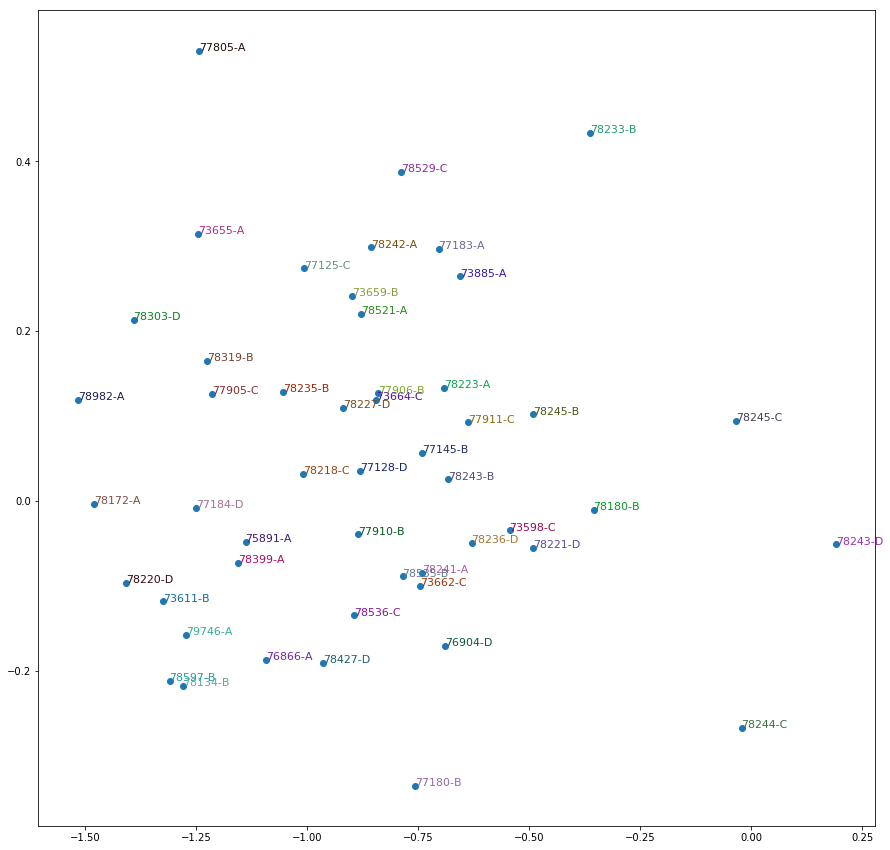

In [0]:
idxs = np.random.choice(len(top_questions), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_questions[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()